In [1]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from graphviz import Digraph

In [65]:
class LocalState():
    def __init__(self,farmer=0,legum=0,sheep=0,wolf=0):
        self.farmer = farmer
        self.legum = legum
        self.sheep = sheep
        self.wolf = wolf
    
    def fromArray(self,data):
        self.legum = data[0]
        self.sheep = data[1]
        self.wolf = data[2]
        self.farmer = data[3]
    
    def fromDict(self,data):
        self.farmer = data["farmer"]
        self.legum = data["legum"]
        self.sheep = data["sheep"]
        self.wolf = data["wolf"]
    
    def toArray(self):
        return np.array([self.legum,self.sheep,self.wolf,self.farmer])
    
    def toDict(self):
        return {"farmer":self.farmer,"legum":self.legum,"sheep":self.sheep,"wolf":self.wolf}
        
class Shore():
    def __init__(self,localState= None):
        
        self.state = (localState if not localState is None else LocalState())
    
    def fromArray(self,data):
        self.state.fromArray(data)
    
    def fromDict(self,data):
        self.state.fromDict(data)
    
    def toArray(self):
        return self.state.toArray()
    
    def toDict(self):
        return self.state.toDict()

class GlobalState():
    def __init__(self,shore1= None,shore2= None):
        self.shore1 = (shore1 if not shore1 is None else Shore())
        self.shore2 = (shore2 if not shore2 is None else Shore())
    
    def fromArray(self,data):
        self.shore1.fromArray(data[0])
        self.shore2.fromArray(data[1])
    
    def fromDict(self,data):
        self.shore1.fromArray(data["shore1"])
        self.shore2.fromArray(data["shore2"])
    
    def toArray(self):
        return np.array([self.shore1.toArray(),self.shore2.toArray()])
    
    def toDict(self):
        return {"shore1":self.shore1.toDict(),"shore2":self.shore2.toDict()}
    
class Operator():
    def __init__(self,name,value,function):
        self.name = name
        self.value = value
        self.function = function
    
    def apply(self,state):
        newState = self.function(state,self.value)
        return newState
        
class Node():
    def __init__(self,state,operator= None,parent= None, childs= None,level = 0):
        self.state = state
        self.operator = operator
        self.parent = parent
        self.childs = childs
        self.level = level

class Method(Enum):
    DEPTH_FIRST = 0
    BREATH_FIRST = 1

class Search():
    def __init__(self,initialState,operators,validation,method= Method.DEPTH_FIRST):
        self.initialState = initialState
        self.curState = initialState
        self.method = method
        self.operators = operators
        self.validation = validation
        self.open = []
        self.memory = {}
        self.level = 0
    
    def reset(self):
        self.curState = self.initialState
        self.open = []
        self.memory = {}
    
    def insertOpen(self,node):
        if self.method == Method.DEPTH_FIRST:
            self.open.insert(0,node)
        else:
            self.open.append(node)
    
    def expand(self,node):
        childs = []
        for op in self.operators:
            child = Node(op.apply(node.state),op,node,level= self.level)
            if str(child.state.toArray()) not in self.memory or str(child.state.toArray()) == str(np.array([[0,0,0,0],[1,1,1,1]])):
                if validation(child.state,op):
                    childs.append(child)
        return childs
    
    def graph(self,root):
        lst = []
        lst.append(root)
        dot = Digraph(comment='Graph of states',format="svg",node_attr={'fontsize': '10'})
        dot.attr(rankdir='LR', size='20,10')
        i = 0
        memory = {}
        while len(lst) > 0:
            node = lst.pop()
            name = 0
            if str(node.state.toArray()) in memory:
                name = memory[str(node.state.toArray())]
                if str(node.state.toArray()) == str(np.array([[0,0,0,0],[1,1,1,1]])):
                    nameN1 = str(memory[str(node.parent.state.toArray())])
                    nameN2 = str(memory[str(node.state.toArray())])
                    dot.edge(nameN1, nameN2, constraint='false')
            else:
                memory[str(node.state.toArray())] = i
                name = memory[str(node.state.toArray())]
                i+= 1
                dot.node(str(name),str(node.state.toDict()))
                if node.parent != None:
                    nameN1 = str(memory[str(node.parent.state.toArray())])
                    nameN2 = str(memory[str(node.state.toArray())])
                    dot.edge(nameN1, nameN2, constraint='false')
            if node.childs != None:
                for child in node.childs:
                    lst.insert(0,child)
        return dot
    
    def search(self):
        self.reset()
        start = Node(self.curState)
        goal = None
        self.insertOpen(start)
        while (len(self.open) > 0):
            node = self.open.pop()
            if str(node.state.toArray()) != str(np.array([[0,0,0,0],[1,1,1,1]])):
                self.memory[str(node.state.toArray())]= "S{}".format(len(self.memory))
                childs = self.expand(node)
                node.childs = childs
                for child in childs:
                    self.insertOpen(child)
        return start

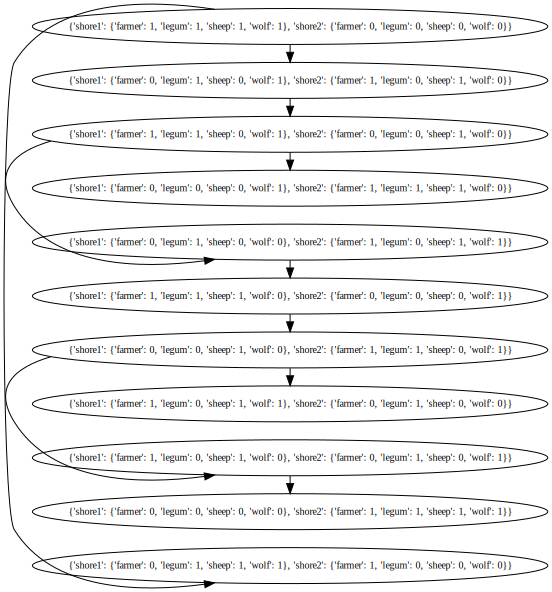

In [66]:
def operation(state,value):
    newState = []
    for shore in state.toArray():
        newShore = []
        for i in range(len(value)):
            newShore.append(shore[i] ^ value[i])
        newShore.append(shore[-1]^1)
        newState.append(newShore)
    res = GlobalState()
    res.fromArray(newState)
    return res
    
def validation(state,op):
    invalidStates = np.array([[0,1,1,0],[1,1,0,0]])
    astate = state.toArray()
    if astate[0][3] != 1:
        for i in range(len(op.value)):
            if op.value[i] == 1 and op.value[i] ^ astate[0][i] == 0:
                return False
    elif astate[1][3] != 1:
        for i in range(len(op.value)):
            if op.value[i] == 1 and op.value[i] ^ astate[1][i] == 0:
                return False
    for invalidState in invalidStates:
        for shore in astate:
            if str(invalidState) == str(shore):
                return False
    return True


curState = GlobalState()
curState.fromArray([[1,1,1,1],[0,0,0,0]])
operValues = {"legum":[1,0,0],"sheep":[0,1,0],"wolf":[0,0,1],"nothing":[0,0,0]}
operators = []
for key in operValues:
    operators.append(Operator(key,operValues[key],operation))
search = Search(curState,operators,validation,Method.BREATH_FIRST)
root = search.search()
search.graph(root)